In [1]:
import datetime
import random
import uuid
from pathlib import Path
import numpy as np
import pandas as pd
from uuid_extensions import uuid7
import matplotlib.pyplot as plt

In [2]:
experiment_uuid_list = [
    uuid7(1733011200000, 'str'),
    uuid7(1733014800000, 'str'),
    uuid7(1733018400000, 'str'),
]
experiment_group_list = ['A', 'B']
event_name_list = [
    'homepage_viewed',
    'product_viewed',
    'product_added_to_cart',
    'order_placed'
]

# Time window: 30 days (in milliseconds)
month_ms = 30 * 24 * 60 * 60 * 1000

# Use a fixed base start date for experiments.
base_start_date = datetime.datetime(2025, 1, 1)

In [3]:
experiment_uuid_list

['0000006c-502d-7e00-8000-4de91bea9183',
 '0000006c-503c-79ee-8000-6a5196e5b0d7',
 '0000006c-504b-75dc-8000-9ff2ec6211db']

In [3]:
def to_epoch_ms(dt):
    """Convert a datetime object to epoch milliseconds."""
    return int(dt.timestamp() * 1000)

def generate_sequential_timestamps(start_ts, num_events, gap_min=60*1000, gap_max=120*60*1000):
    """
    Generate a list of sequential timestamps (in ms) starting from start_ts.
    Each subsequent timestamp is incremented by a random gap (between gap_min and gap_max).
    """
    timestamps = [start_ts]
    current_ts = start_ts
    for _ in range(1, num_events):
        gap = random.randint(gap_min, gap_max)
        current_ts += gap
        timestamps.append(current_ts)
    return timestamps

def generate_event_count(mean, std, min_val, max_val):
    """
    Generate an integer event count from a normal distribution.
    The value is clipped to be between min_val and max_val.
    """
    count = int(np.round(np.random.normal(mean, std)))
    return max(min_val, min(max_val, count))

In [11]:
np.random.seed(42)
random.seed(42)

events_homepage = []
events_product = []
events_cart = []
events_order = []
event_review = []

# To keep track of the last event timestamp per user for funnel progression.
# Structure: funnel_last_ts[event_type][experiment_uuid][group][user_uuid] = last event_ts
funnel_last_ts = {
    'homepage_viewed': {},
    'product_viewed': {},
    'product_added_to_cart': {},
    'order_placed': {}
}

# To store users at each funnel stage.
# Structure: users_stage[experiment_uuid][group] = list of user_uuid
users_homepage = {}
users_product = {}
users_cart = {}
users_order = {}

uplift = 0.05

for exp_idx, experiment_uuid in enumerate(experiment_uuid_list):
    exp_start = to_epoch_ms(base_start_date + datetime.timedelta(days=exp_idx * 31))
    exp_end = exp_start + month_ms

    funnel_last_ts['homepage_viewed'].setdefault(experiment_uuid, {})
    funnel_last_ts['product_viewed'].setdefault(experiment_uuid, {})
    funnel_last_ts['product_added_to_cart'].setdefault(experiment_uuid, {})
    funnel_last_ts['order_placed'].setdefault(experiment_uuid, {})
    users_homepage.setdefault(experiment_uuid, {})
    users_product.setdefault(experiment_uuid, {})
    users_cart.setdefault(experiment_uuid, {})
    users_order.setdefault(experiment_uuid, {})

    for group in experiment_group_list:
        # --- Homepage Viewed ---
        num_users_homepage = random.randint(9500, 10500)
        users_homepage[experiment_uuid][group] = []
        funnel_last_ts['homepage_viewed'][experiment_uuid].setdefault(group, {})

        for _ in range(num_users_homepage):
            user_uuid = str(uuid.uuid4())
            users_homepage[experiment_uuid][group].append(user_uuid)
            # Generate number of homepage events (range: 1-100, inferred mean ~20, std ~10)
            count = generate_event_count(mean=20, std=10, min_val=1, max_val=100)
            # Ensure the user's events fit in the experiment window:
            max_possible_duration = (count - 1) * (120 * 60 * 1000)
            if exp_end - max_possible_duration > exp_start:
                user_start = random.randint(exp_start, exp_end - max_possible_duration)
            else:
                user_start = exp_start
            timestamps = generate_sequential_timestamps(user_start, count)
            # Record the last timestamp for funnel progression
            funnel_last_ts['homepage_viewed'][experiment_uuid][group][user_uuid] = timestamps[-1]
            # Create event rows
            for ts in timestamps:
                events_homepage.append({
                    'event_uuid': uuid7(ts, 'str'),
                    'event_name': 'homepage_viewed',
                    'experiment_uuid': experiment_uuid,
                    'experiment_group': group,
                    'user_uuid': user_uuid,
                    'event_ts': ts
                })

        # --- Product Viewed ---
        # Select a subset of homepage users.
        homepage_users = users_homepage[experiment_uuid][group]
        num_users_product = random.randint(4500, 5500)
        if group == 'B':
            num_users_product = int(num_users_product * (1 + uplift))
        # Randomly select non-intersecting users.
        product_users = random.sample(homepage_users, num_users_product)
        users_product[experiment_uuid][group] = product_users
        funnel_last_ts['product_viewed'][experiment_uuid].setdefault(group, {})

        for user_uuid in product_users:
            count = generate_event_count(mean=5, std=2, min_val=1, max_val=50)
            last_home_ts = funnel_last_ts['homepage_viewed'][experiment_uuid][group][user_uuid]
            max_possible_duration = (count - 1) * (120 * 60 * 1000)
            min_start = last_home_ts + 1  # ensure strictly after homepage event
            if exp_end - max_possible_duration > min_start:
                user_start = random.randint(min_start, exp_end - max_possible_duration)
            else:
                user_start = min_start
            timestamps = generate_sequential_timestamps(user_start, count)
            funnel_last_ts['product_viewed'][experiment_uuid][group][user_uuid] = timestamps[-1]
            for ts in timestamps:
                events_product.append({
                    'event_uuid': uuid7(ts, 'str'),
                    'event_name': 'product_viewed',
                    'experiment_uuid': experiment_uuid,
                    'experiment_group': group,
                    'user_uuid': user_uuid,
                    'event_ts': ts
                })

        # --- Product Added to Cart ---
        # Select a subset of product_viewed users.
        product_users_list = users_product[experiment_uuid][group]
        num_users_cart = random.randint(1500, 2500)
        if group == 'B':
            num_users_cart = int(num_users_cart * (1 + uplift))
        cart_users = random.sample(product_users_list, num_users_cart)
        users_cart[experiment_uuid][group] = cart_users
        funnel_last_ts['product_added_to_cart'][experiment_uuid].setdefault(group, {})

        for user_uuid in cart_users:
            count = generate_event_count(mean=3, std=1, min_val=1, max_val=20)
            last_product_ts = funnel_last_ts['product_viewed'][experiment_uuid][group][user_uuid]
            max_possible_duration = (count - 1) * (120 * 60 * 1000)
            min_start = last_product_ts + 1
            if exp_end - max_possible_duration > min_start:
                user_start = random.randint(min_start, exp_end - max_possible_duration)
            else:
                user_start = min_start
            timestamps = generate_sequential_timestamps(user_start, count)
            funnel_last_ts['product_added_to_cart'][experiment_uuid][group][user_uuid] = timestamps[-1]
            for ts in timestamps:
                events_cart.append({
                    'event_uuid': uuid7(ts, 'str'),
                    'event_name': 'product_added_to_cart',
                    'experiment_uuid': experiment_uuid,
                    'experiment_group': group,
                    'user_uuid': user_uuid,
                    'event_ts': ts
                })

        # --- Order Placed ---
        # Select a subset of users from product_added_to_cart.
        cart_users_list = users_cart[experiment_uuid][group]
        num_users_order = random.randint(400, 600)
        if group == 'B':
            num_users_order = int(num_users_order * (1 + uplift))
        order_users = random.sample(cart_users_list, num_users_order)
        users_order[experiment_uuid][group] = order_users
        funnel_last_ts['order_placed'][experiment_uuid].setdefault(group, {})

        for user_uuid in order_users:
            count = generate_event_count(mean=2, std=1, min_val=1, max_val=5)
            last_cart_ts = funnel_last_ts['product_added_to_cart'][experiment_uuid][group][user_uuid]
            max_possible_duration = (count - 1) * (120 * 60 * 1000)
            min_start = last_cart_ts + 1
            if exp_end - max_possible_duration > min_start:
                user_start = random.randint(min_start, exp_end - max_possible_duration)
            else:
                user_start = min_start
            timestamps = generate_sequential_timestamps(user_start, count)
            funnel_last_ts['order_placed'][experiment_uuid][group][user_uuid] = timestamps[-1]
            for ts in timestamps:
                events_order.append({
                    'event_uuid': uuid7(ts, 'str'),
                    'event_name': 'order_placed',
                    'experiment_uuid': experiment_uuid,
                    'experiment_group': group,
                    'user_uuid': user_uuid,
                    'event_ts': ts
                })

        # --- Review Written ---
        # Select a subset of users from order_placed.
        order_users_list = users_order[experiment_uuid][group]
        num_users_review = random.randint(80, 120)
        if group == 'B':
            num_users_review = int(num_users_review * (1 + uplift))
        review_users = random.sample(order_users_list, num_users_review)

        for user_uuid in review_users:
            count = generate_event_count(mean=2, std=1, min_val=1, max_val=3)
            last_review_ts = funnel_last_ts['order_placed'][experiment_uuid][group][user_uuid]
            max_possible_duration = (count - 1) * (120 * 60 * 1000)
            min_start = last_review_ts + 1
            if exp_end - max_possible_duration > min_start:
                user_start = random.randint(min_start, exp_end - max_possible_duration)
            else:
                user_start = min_start
            timestamps = generate_sequential_timestamps(user_start, count)
            for ts in timestamps:
                event_review.append({
                    'event_uuid': uuid7(ts, 'str'),
                    'event_name': 'review_written',
                    'experiment_uuid': experiment_uuid,
                    'experiment_group': group,
                    'user_uuid': user_uuid,
                    'event_ts': ts
                })


df_homepage = pd.DataFrame(events_homepage)
df_product = pd.DataFrame(events_product)
df_cart = pd.DataFrame(events_cart)
df_order = pd.DataFrame(events_order)
df_review = pd.DataFrame(event_review)

df_homepage.sort_values('event_ts', inplace=True)
df_product.sort_values('event_ts', inplace=True)
df_cart.sort_values('event_ts', inplace=True)
df_order.sort_values('event_ts', inplace=True)
df_review.sort_values('event_ts', inplace=True)

Path('data').mkdir(parents=True, exist_ok=True)
df_homepage.to_csv('data/homepage_viewed.csv', index=False)
df_product.to_csv('data/product_viewed.csv', index=False)
df_cart.to_csv('data/product_added_to_cart.csv', index=False)
df_order.to_csv('data/order_placed.csv', index=False)
df_review.to_csv('data/review_written.csv', index=False)

print("CSV files generated successfully!")

CSV files generated successfully!


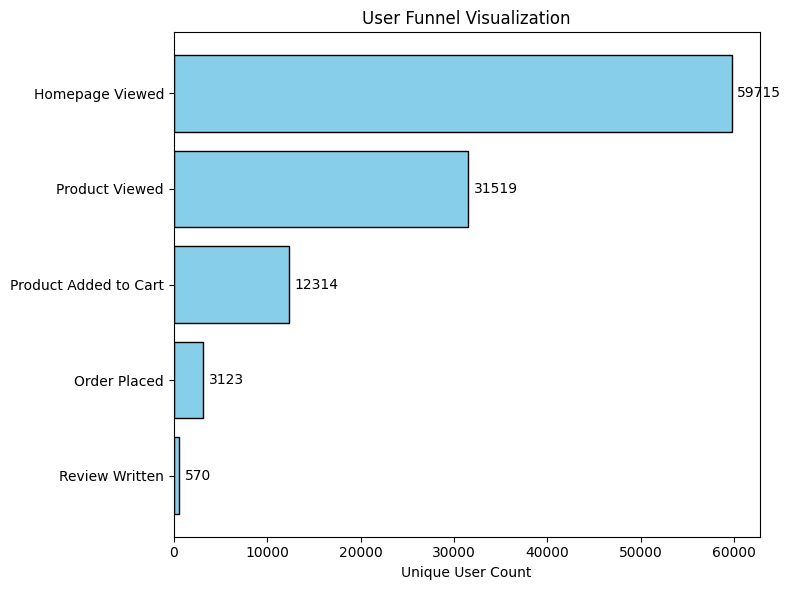

In [12]:
count_homepage = df_homepage['user_uuid'].nunique()
count_product = df_product['user_uuid'].nunique()
count_cart = df_cart['user_uuid'].nunique()
count_order = df_order['user_uuid'].nunique()
count_review = df_review['user_uuid'].nunique()

stages = ["Homepage Viewed", "Product Viewed", "Product Added to Cart", "Order Placed", "Review Written"]
counts = [count_homepage, count_product, count_cart, count_order, count_review]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(stages, counts, color='skyblue', edgecolor='black')
ax.invert_yaxis()
ax.set_xlabel("Unique User Count")
ax.set_title("User Funnel Visualization")

for bar in bars:
    width = bar.get_width()
    ax.text(width + max(counts) * 0.01, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

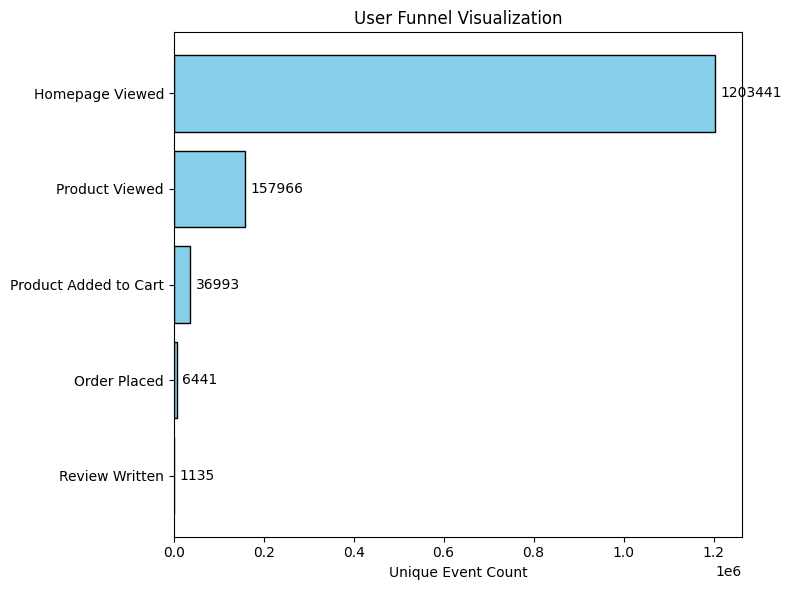

In [14]:
count_homepage = df_homepage['event_uuid'].nunique()
count_product = df_product['event_uuid'].nunique()
count_cart = df_cart['event_uuid'].nunique()
count_order = df_order['event_uuid'].nunique()
count_review = df_review['event_uuid'].nunique()

stages = ["Homepage Viewed", "Product Viewed", "Product Added to Cart", "Order Placed", "Review Written"]
counts = [count_homepage, count_product, count_cart, count_order, count_review]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(stages, counts, color='skyblue', edgecolor='black')
ax.invert_yaxis()
ax.set_xlabel("Unique Event Count")
ax.set_title("User Funnel Visualization")

for bar in bars:
    width = bar.get_width()
    ax.text(width + max(counts) * 0.01, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontsize=10)

plt.tight_layout()
plt.show()